# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import tensorflow
from tensorflow import keras


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them

def load_bundle_csv(file_dict):
    dfs = []

    for filename, filepath in file_dict.items():
            df = pd.read_csv(filepath)
            df = df.rename(columns={
            'Open': f'Open{filename}',
            'High': f'High{filename}',
            'Low': f'Low{filename}',
            'Close': f'Close{filename}',
            'Volume': f'Volume{filename}'
        })
            df.drop("Name",axis=1,inplace=True)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index("Date",inplace=True)
            dfs.append(df)

    integrated_df = dfs[0]
    for df in dfs[1:]:
      integrated_df = integrated_df.join(df,how='outer',on="Date")
    integrated_df.reset_index(inplace=True,drop=True)
    return integrated_df


In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

file_dictionary = {
    'AMZN': '/Users/shounak/Desktop/Upgrad Projects/Stock Price Prediction/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/AMZN_stocks_data.csv',
    'GOOGL': '/Users/shounak/Desktop/Upgrad Projects/Stock Price Prediction/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/GOOGL_stocks_data.csv',
    'IBM': '/Users/shounak/Desktop/Upgrad Projects/Stock Price Prediction/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/IBM_stocks_data.csv',
    'MSFT': '/Users/shounak/Desktop/Upgrad Projects/Stock Price Prediction/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/MSFT_stocks_data.csv'
}

integrated_df = load_bundle_csv(file_dict=file_dictionary)

In [4]:
integrated_df.head()

,Date,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,...,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,...,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
1,2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,...,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2,2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,...,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
3,2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,...,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
4,2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,...,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


In [5]:
# View specifics of the data

# Display the first 5 rows
print(" Preview: First 5 Rows of the Integrated DataFrame\n")
print(integrated_df.head(), "\n")

# Display summary statistics for numeric columns
print(" Descriptive Statistics (Numerical Columns Only)\n")
print(integrated_df.describe(), "\n")

# Display the shape of the DataFrame
num_rows, num_cols = integrated_df.shape
print(f" Shape of the DataFrame:\n- Rows: {num_rows}\n- Columns: {num_cols}\n")

print(" Data Types of Each Column:\n")
print(integrated_df.dtypes, "\n")



 Preview: First 5 Rows of the Integrated DataFrame

        Date  OpenAMZN  HighAMZN  LowAMZN  CloseAMZN  VolumeAMZN  OpenGOOGL  \
0 2006-01-03     47.47     47.85    46.25      47.58   7582127.0     211.47   
1 2006-01-04     47.48     47.73    46.69      47.25   7440914.0     222.17   
2 2006-01-05     47.16     48.20    47.11      47.65   5417258.0     223.22   
3 2006-01-06     47.97     48.58    47.32      47.87   6154285.0     228.66   
4 2006-01-09     46.55     47.10    46.40      47.08   8945056.0     233.44   

   HighGOOGL  LowGOOGL  CloseGOOGL  ...  OpenIBM  HighIBM  LowIBM  CloseIBM  \
0     218.05    209.32      217.83  ...    82.45    82.55   80.81     82.06   
1     224.70    220.09      222.84  ...    82.20    82.50   81.33     81.95   
2     226.00    220.97      225.85  ...    81.40    82.90   81.00     82.50   
3     235.49    226.85      233.06  ...    83.95    85.03   83.41     84.95   
4     236.94    230.70      233.68  ...    84.10    84.25   83.38     83.73   

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [6]:
# Handle Missing Values

integrated_df.isna().sum()

Date           0
OpenAMZN       1
HighAMZN       1
LowAMZN        1
CloseAMZN      1
VolumeAMZN     1
OpenGOOGL      1
HighGOOGL      1
LowGOOGL       1
CloseGOOGL     1
VolumeGOOGL    1
OpenIBM        1
HighIBM        0
LowIBM         1
CloseIBM       0
VolumeIBM      0
OpenMSFT       1
HighMSFT       1
LowMSFT        1
CloseMSFT      1
VolumeMSFT     1
dtype: int64

In [7]:
#Identify and printing the indexes of rows with missing values

missing_indexes = integrated_df.isnull().loc[lambda x: x.any(axis=1)].index.tolist()
print("Indexes of missing values:", missing_indexes)

Indexes of missing values: [2912, 3019]


In [8]:
# Drop rows with missing values
integrated_df.dropna(inplace=True)
# Reset the index after dropping rows
integrated_df.reset_index(drop=True, inplace=True)
# Display the shape of the DataFrame after dropping missing values
print(f"Shape of the DataFrame after dropping missing values: {integrated_df.shape}\n")
# Display the first 5 rows after handling missing values
print("First 5 Rows After Handling Missing Values:\n")
print(integrated_df.head(), "\n")
# Display the number of missing values in each column after handling
print("Number of Missing Values in Each Column After Handling:\n")
print(integrated_df.isnull().sum(), "\n")
# Display the data types of each column after handling missing values
print("Data Types of Each Column After Handling Missing Values:\n")
print(integrated_df.dtypes, "\n")  

Shape of the DataFrame after dropping missing values: (3018, 21)

First 5 Rows After Handling Missing Values:

        Date  OpenAMZN  HighAMZN  LowAMZN  CloseAMZN  VolumeAMZN  OpenGOOGL  \
0 2006-01-03     47.47     47.85    46.25      47.58   7582127.0     211.47   
1 2006-01-04     47.48     47.73    46.69      47.25   7440914.0     222.17   
2 2006-01-05     47.16     48.20    47.11      47.65   5417258.0     223.22   
3 2006-01-06     47.97     48.58    47.32      47.87   6154285.0     228.66   
4 2006-01-09     46.55     47.10    46.40      47.08   8945056.0     233.44   

   HighGOOGL  LowGOOGL  CloseGOOGL  ...  OpenIBM  HighIBM  LowIBM  CloseIBM  \
0     218.05    209.32      217.83  ...    82.45    82.55   80.81     82.06   
1     224.70    220.09      222.84  ...    82.20    82.50   81.33     81.95   
2     226.00    220.97      225.85  ...    81.40    82.90   81.00     82.50   
3     235.49    226.85      233.06  ...    83.95    85.03   83.41     84.95   
4     236.94    230

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

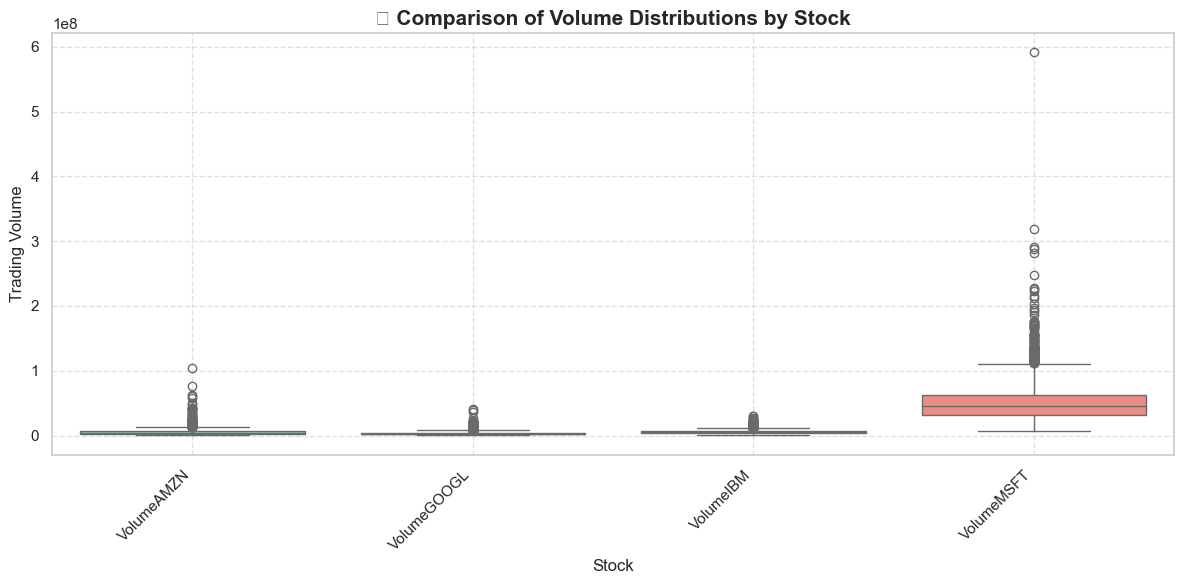

In [9]:
# Frequency distribution of volumes

# Identify all columns containing 'Volume'
volume_columns = [col for col in integrated_df.columns if 'Volume' in col]

# Optional: Reshape for better seaborn compatibility (long format)
volume_data = integrated_df[volume_columns].melt(var_name='Stock', value_name='Volume')

# Set plot style
sns.set(style="whitegrid", palette="Set2")

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=volume_data, x='Stock', y='Volume', palette='Set3')

# Optional: Log scale to handle skewed volumes
# plt.yscale('log')

# Add plot labels and title
plt.title('📦 Comparison of Volume Distributions by Stock', fontsize=15, fontweight='bold')
plt.xlabel('Stock', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Optional: Save the figure
# plt.savefig('volume_comparison_boxplot.png', dpi=300)

plt.show()




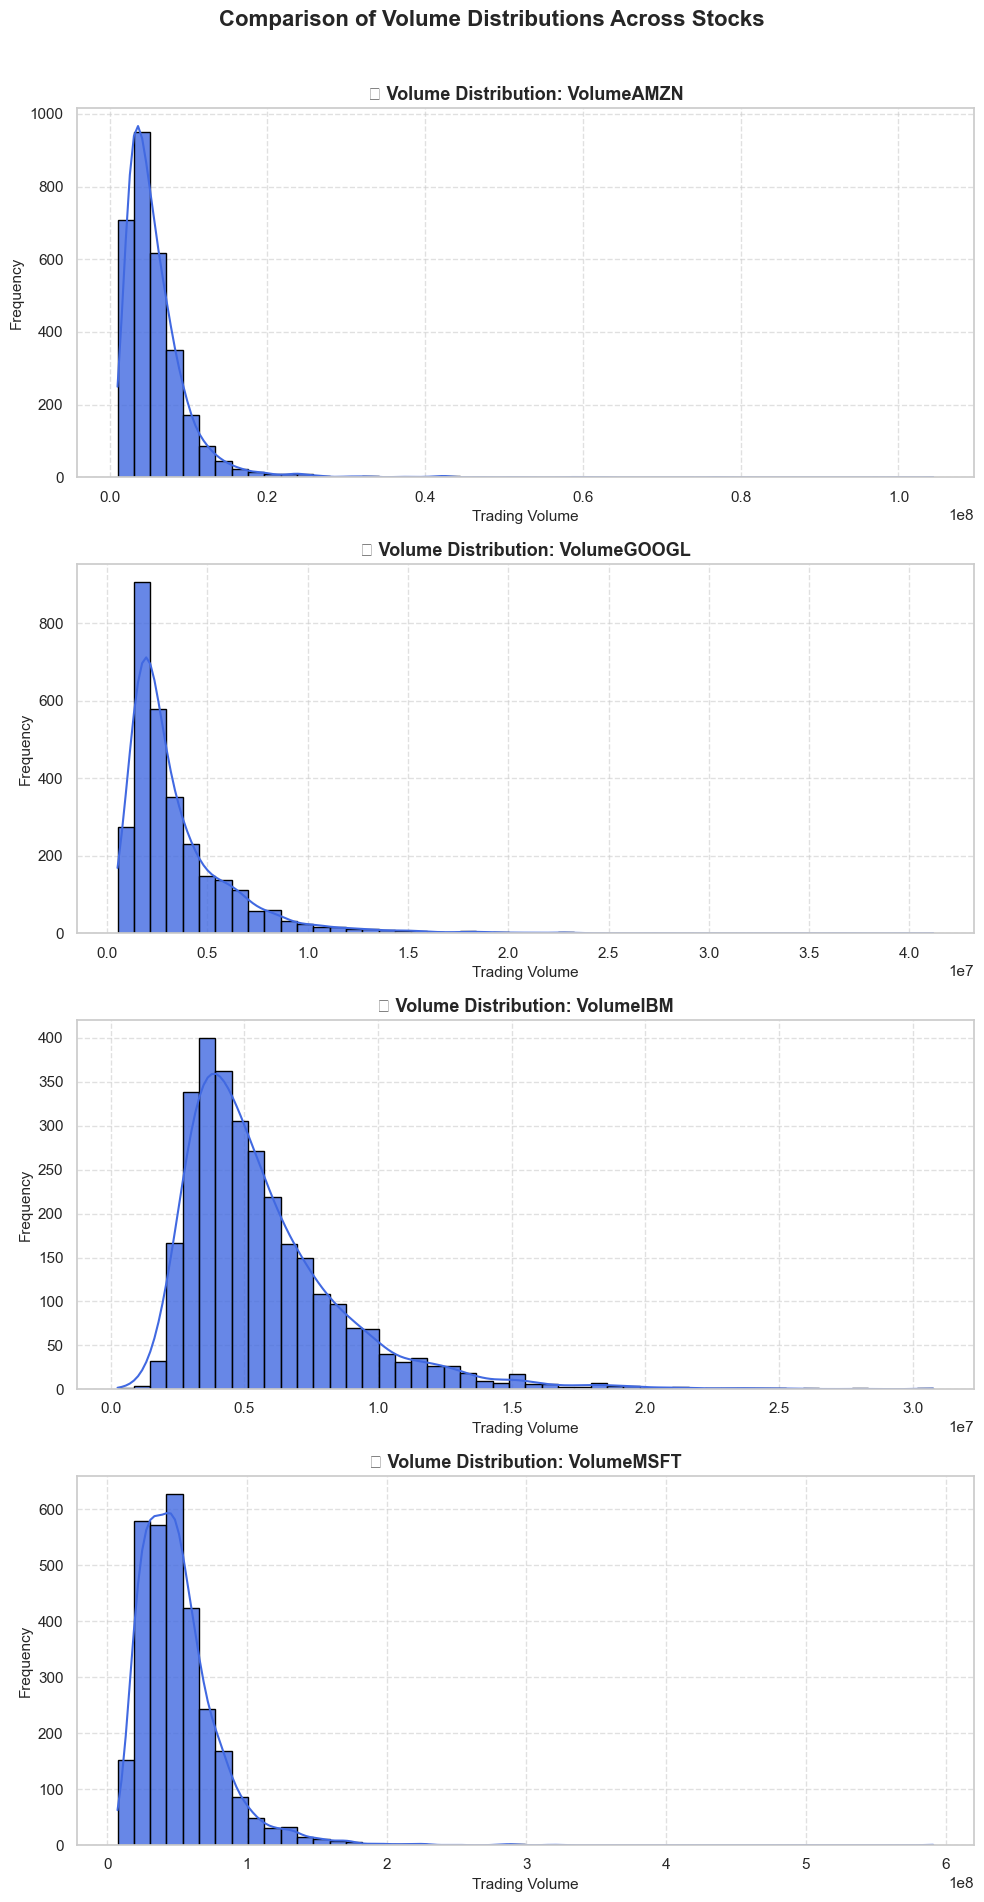

In [10]:
# Set seaborn style for cleaner visuals
sns.set(style="whitegrid")

# Number of plots
num_cols = len(volume_columns)

# Create subplots dynamically based on the number of volume columns
fig, axs = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 5 * num_cols), constrained_layout=True)

# If only one plot, axs won't be iterable
if num_cols == 1:
    axs = [axs]

# Plot each volume distribution
for i, col in enumerate(volume_columns):
    sns.histplot(data=integrated_df, x=col, bins=50, kde=True, ax=axs[i], color='royalblue', edgecolor='black', alpha=0.8)
    axs[i].set_title(f'📊 Volume Distribution: {col}', fontsize=13, fontweight='bold')
    axs[i].set_xlabel('Trading Volume', fontsize=11)
    axs[i].set_ylabel('Frequency', fontsize=11)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    
    # Optional: Use log scale for skewed distributions
    # axs[i].set_xscale('log')

# Overall figure title (optional)
fig.suptitle('Comparison of Volume Distributions Across Stocks', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

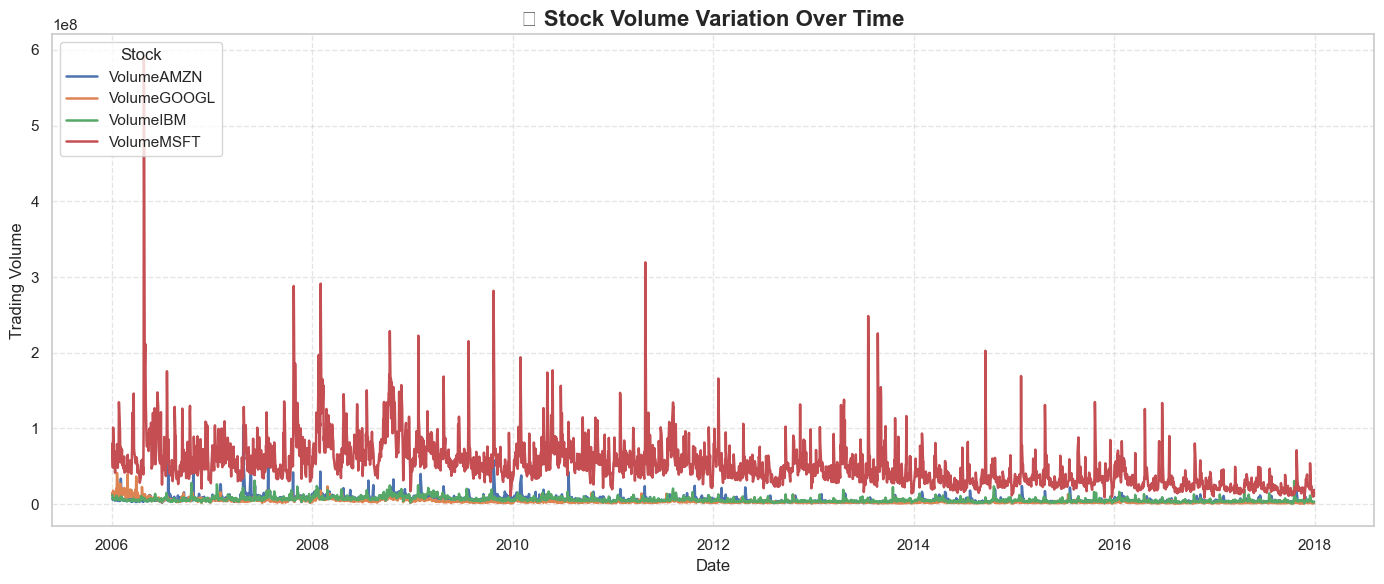

In [11]:
# Stock volume variation over time

integrated_df['Date'] = pd.to_datetime(integrated_df['Date'])
merged_df = integrated_df.sort_values('Date')

# Set visual style
sns.set(style="whitegrid")

# Plot volume over time for each stock
plt.figure(figsize=(14, 6))

for col in volume_columns:
    plt.plot(integrated_df['Date'], integrated_df[col], label=col, linewidth=1.8)

plt.title('📈 Stock Volume Variation Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.legend(title='Stock', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


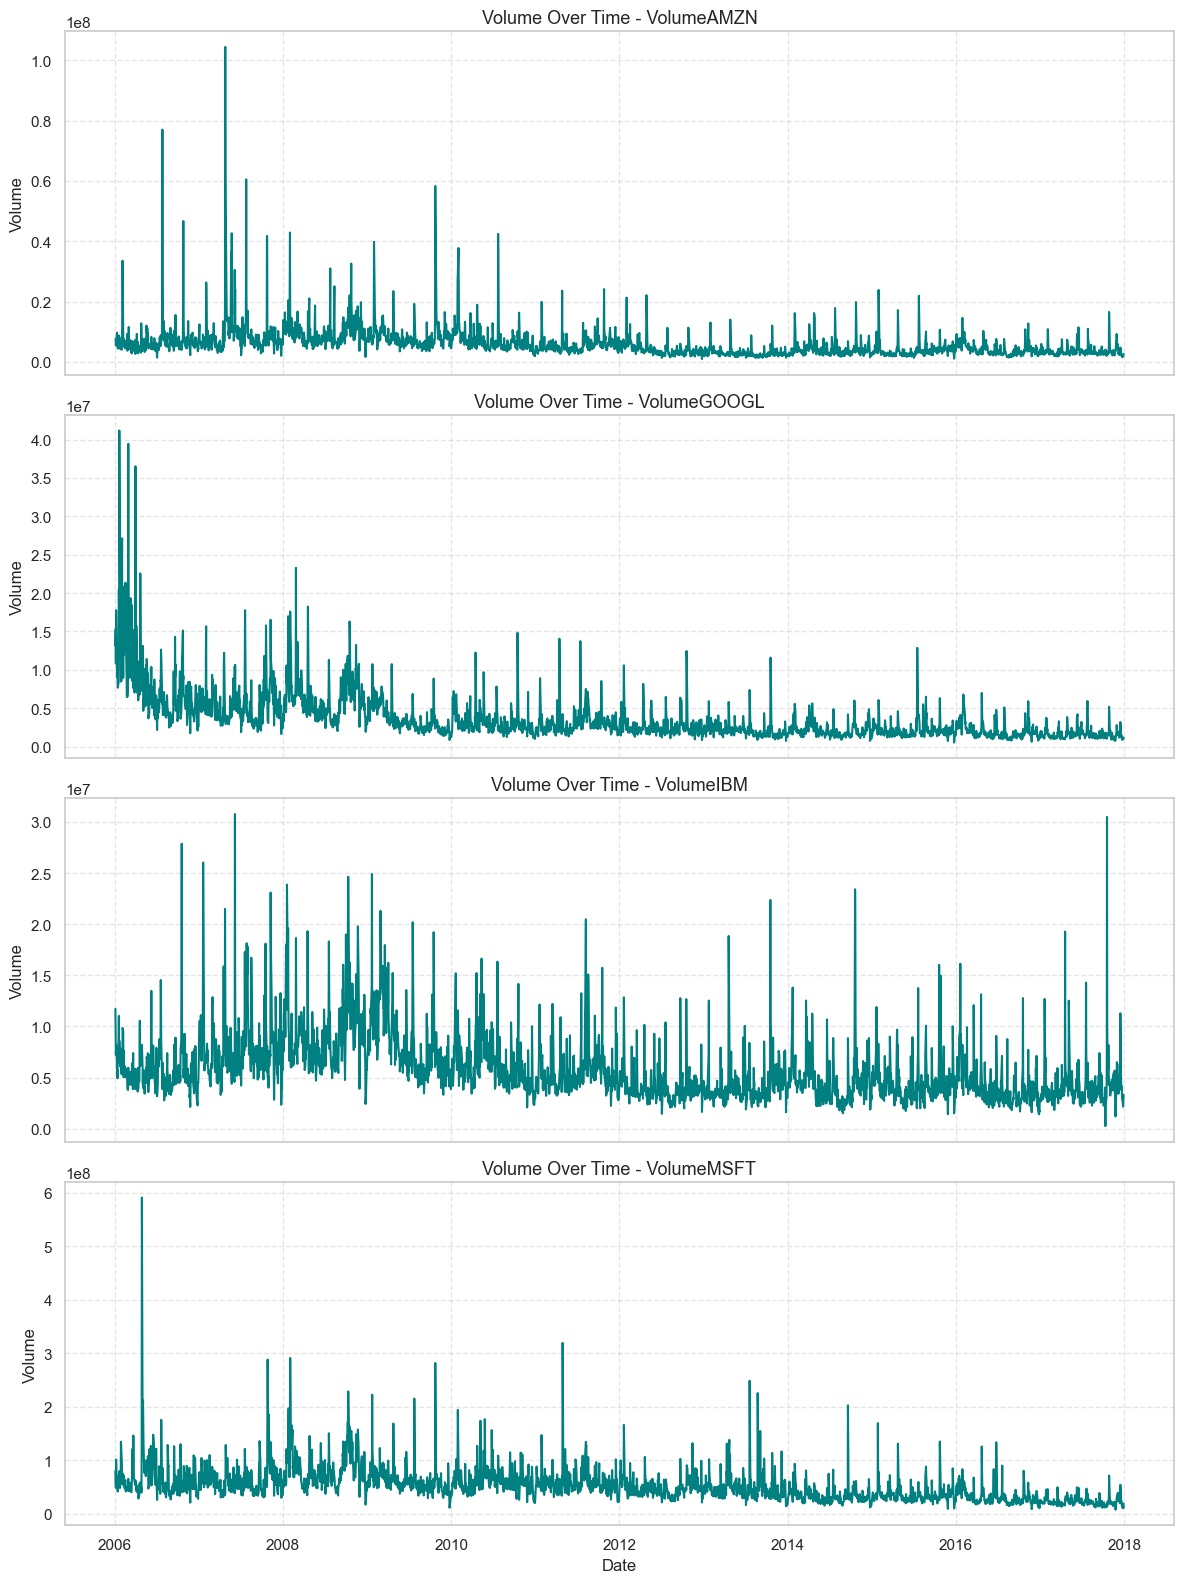

In [12]:
# Individual Subplots Per Stock
fig, axs = plt.subplots(nrows=len(volume_columns), ncols=1, figsize=(12, 4 * len(volume_columns)), sharex=True)

for i, col in enumerate(volume_columns):
    axs[i].plot(integrated_df['Date'], integrated_df[col], color='teal', linewidth=1.5)
    axs[i].set_title(f'Volume Over Time - {col}', fontsize=13)
    axs[i].set_ylabel('Volume')
    axs[i].grid(True, linestyle='--', alpha=0.5)

axs[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [13]:
# Analyse correlations

integrated_df.corr()


,Date,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,...,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
Date,1.000000,0.891153,0.891906,0.890566,0.891242,-0.406418,0.900102,0.900047,0.900429,0.900265,...,0.680893,0.679650,0.680828,0.679874,-0.442726,0.814189,0.814357,0.813921,0.814448,-0.515620
OpenAMZN,0.891153,1.000000,0.999931,0.999897,0.999834,-0.328318,0.972644,0.972504,0.972994,0.972735,...,0.396641,0.393732,0.397839,0.395173,-0.372165,0.953434,0.953345,0.953419,0.953446,-0.488958
HighAMZN,0.891906,0.999931,1.000000,0.999889,0.999924,-0.326409,0.972767,0.972710,0.973154,0.972955,...,0.397116,0.394265,0.398315,0.395709,-0.371636,0.953299,0.953281,0.953304,0.953392,-0.488203
LowAMZN,0.890566,0.999897,0.999889,1.000000,0.999930,-0.330015,0.972317,0.972215,0.972828,0.972567,...,0.396266,0.393356,0.397539,0.394865,-0.373330,0.953503,0.953436,0.953625,0.953644,-0.490040
CloseAMZN,0.891242,0.999834,0.999924,0.999930,1.000000,-0.328009,0.972482,0.972442,0.972984,0.972817,...,0.396644,0.393798,0.397919,0.395349,-0.372818,0.953331,0.953326,0.953443,0.953563,-0.489236
VolumeAMZN,-0.406418,-0.328318,-0.326409,-0.330015,-0.328009,1.000000,-0.335282,-0.334037,-0.337847,-0.336239,...,-0.389324,-0.386539,-0.392234,-0.389026,0.390736,-0.279138,-0.277289,-0.282671,-0.280460,0.384698
OpenGOOGL,0.900102,0.972644,0.972767,0.972317,0.972482,-0.335282,1.000000,0.999894,0.999841,0.999743,...,0.411837,0.408774,0.413145,0.410178,-0.384548,0.968742,0.968778,0.968578,0.968750,-0.510437
HighGOOGL,0.900047,0.972504,0.972710,0.972215,0.972442,-0.334037,0.999894,1.000000,0.999827,0.999866,...,0.410579,0.407616,0.411906,0.409028,-0.382638,0.968652,0.968803,0.968520,0.968788,-0.509071
LowGOOGL,0.900429,0.972994,0.973154,0.972828,0.972984,-0.337847,0.999841,0.999827,1.000000,0.999896,...,0.413376,0.410321,0.414849,0.411868,-0.387848,0.968731,0.968789,0.968764,0.968928,-0.513416
CloseGOOGL,0.900265,0.972735,0.972955,0.972567,0.972817,-0.336239,0.999743,0.999866,0.999896,1.000000,...,0.411987,0.409043,0.413462,0.410647,-0.385487,0.968578,0.968737,0.968606,0.968930,-0.511782


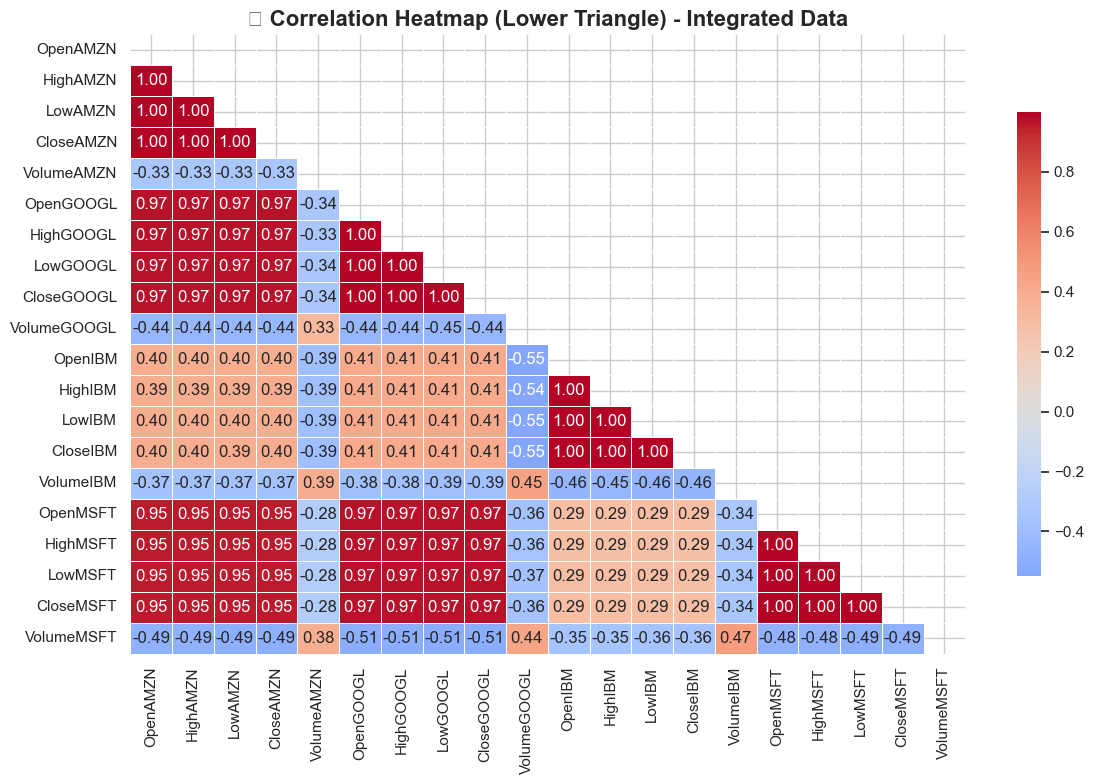

In [14]:
#Visualize the correlation matrix

# Calculate correlation matrix (only numeric columns)
corr_matrix = integrated_df.corr(numeric_only=True)

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set plot size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot heatmap with mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title('🔗 Correlation Heatmap (Lower Triangle) - Integrated Data', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
#Finding pairs for which the correlation is greater than 0.8
corr_matrix = integrated_df.corr()
threshold = 0.89
highly_correlated_columns = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            highly_correlated_columns.add(tuple(sorted((col1, col2))))

# Convert to list and sort by absolute correlation ascending
sorted_corr = sorted(
    highly_correlated_columns, 
    key=lambda x: abs(corr_matrix.loc[x[0], x[1]])
)

print("Highly Correlated Column Pairs (|corr| > 0.8) in ascending order:\n")
for col1, col2 in sorted_corr:
    corr_val = corr_matrix.loc[col1, col2]
    print(f"{col1} and {col2}: {corr_val:.3f}")



Highly Correlated Column Pairs (|corr| > 0.8) in ascending order:

Date and LowAMZN: 0.891
Date and OpenAMZN: 0.891
CloseAMZN and Date: 0.891
Date and HighAMZN: 0.892
Date and HighGOOGL: 0.900
Date and OpenGOOGL: 0.900
CloseGOOGL and Date: 0.900
Date and LowGOOGL: 0.900
HighAMZN and HighMSFT: 0.953
HighAMZN and OpenMSFT: 0.953
HighAMZN and LowMSFT: 0.953
CloseAMZN and HighMSFT: 0.953
CloseAMZN and OpenMSFT: 0.953
HighMSFT and OpenAMZN: 0.953
CloseMSFT and HighAMZN: 0.953
LowMSFT and OpenAMZN: 0.953
OpenAMZN and OpenMSFT: 0.953
HighMSFT and LowAMZN: 0.953
CloseAMZN and LowMSFT: 0.953
CloseMSFT and OpenAMZN: 0.953
LowAMZN and OpenMSFT: 0.954
CloseAMZN and CloseMSFT: 0.954
LowAMZN and LowMSFT: 0.954
CloseMSFT and LowAMZN: 0.954
HighGOOGL and LowMSFT: 0.969
CloseGOOGL and OpenMSFT: 0.969
LowMSFT and OpenGOOGL: 0.969
CloseGOOGL and LowMSFT: 0.969
HighGOOGL and OpenMSFT: 0.969
LowGOOGL and OpenMSFT: 0.969
CloseGOOGL and HighMSFT: 0.969
OpenGOOGL and OpenMSFT: 0.969
CloseMSFT and OpenGOOGL: 0

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [16]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size, step_size, target_names, verbose=False):
    
    X_windowed, y_windowed = [], []
    target_cols = [f'Close{t}' for t in target_names]
    
    missing = [c for c in target_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing target columns in dataframe: {missing}")
    
    for i in range(0, len(df) - window_size - 1, step_size):
        window_df = df.iloc[i:i + window_size + 1]
        X = window_df.iloc[:-1].drop(columns=target_cols)
        y = window_df[target_cols].iloc[-1:]
        X_windowed.append(X)
        y_windowed.append(y)
        
        if verbose and i % (10 * step_size) == 0:
            print(f"Processed window starting at index {i}")
            
    return X_windowed, y_windowed



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [17]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
from typing import List, Optional, Tuple, Union 
def scale_data(
    X_windowed: List[pd.DataFrame], 
    y_windowed: Optional[List[pd.DataFrame]] = None
) -> Tuple[List[np.ndarray], Optional[List[np.ndarray]]]:
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Concatenate all X windows vertically to fit scaler globally on numeric columns
    all_X = pd.concat(X_windowed, axis=0)
    numeric_columns = all_X.select_dtypes(include=['int64', 'float64']).columns
    scaler_X.fit(all_X[numeric_columns])
    
    if y_windowed is not None:
        all_y = pd.concat(y_windowed, axis=0)
        scaler_y.fit(all_y)
    
    X_scaled_windowed = []
    for X in X_windowed:
        X_num_scaled = scaler_X.transform(X[numeric_columns])
        # Replace only numeric columns with scaled, keep other columns if any unchanged
        X_scaled = X.copy()
        X_scaled.loc[:, numeric_columns] = X_num_scaled
        X_scaled_windowed.append(X_scaled.values)
    
    y_scaled_windowed = None
    if y_windowed is not None:
        y_scaled_windowed = []
        for y in y_windowed:
            y_scaled = scaler_y.transform(y)
            y_scaled_windowed.append(y_scaled)
    
    return X_scaled_windowed, y_scaled_windowed


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [18]:
# Define a function to create input and output data points from the master DataFrame

def master_function(master_df, target_stocks, window_size, window_stride, train_test_ratio):
    X_windowed, y_windowed = create_windowed_data(master_df, window_size, window_stride, target_stocks)

    X_windowed_scaled, y_windowed_scaled = scale_data(X_windowed, y_windowed)

    # Use train_size and no shuffle to keep time order
    X_train, X_test, y_train, y_test = train_test_split(
        X_windowed_scaled, y_windowed_scaled,
        train_size=train_test_ratio,
        random_state=42,
        shuffle=False
    )

    return X_train, y_train, X_test, y_test



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

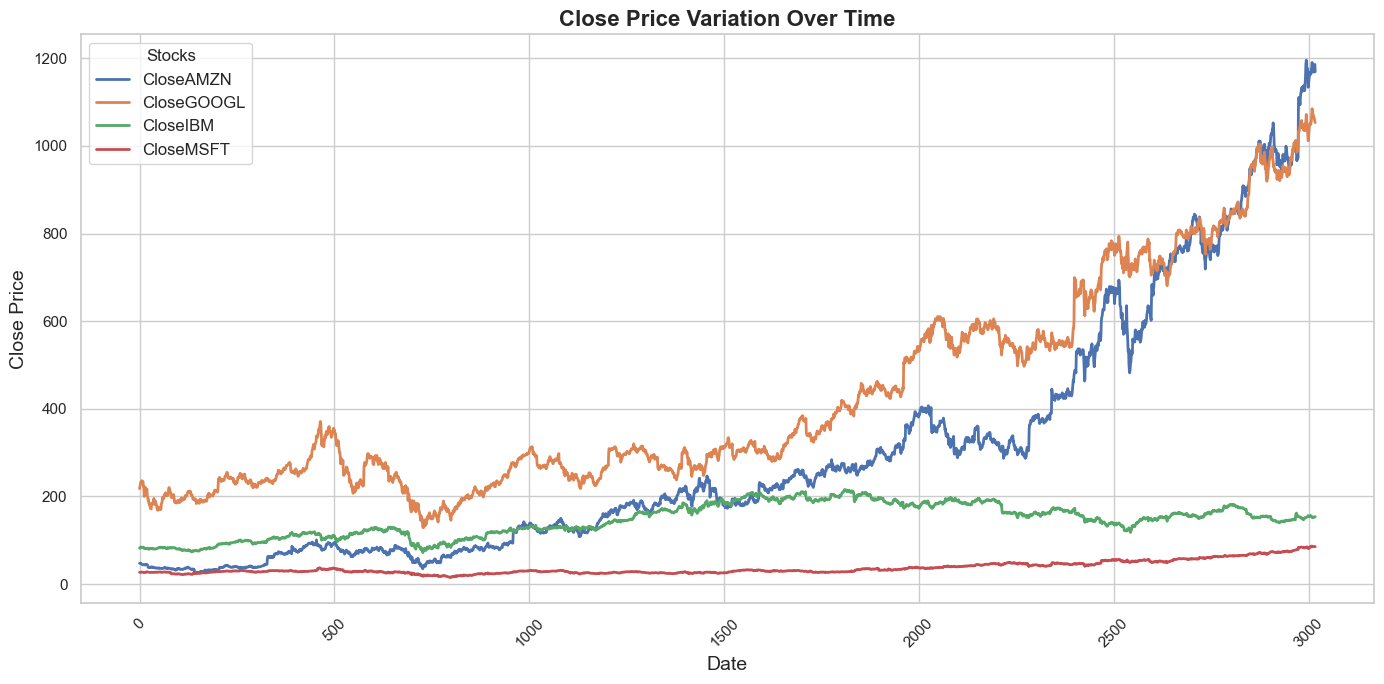

In [19]:
# Checking for patterns in different sequence lengths

close_columns = [col for col in integrated_df.columns if 'Close' in col]

plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')

for col in close_columns:
    plt.plot(integrated_df.index, integrated_df[col], label=col, linewidth=2)

plt.title('Close Price Variation Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend(title='Stocks', loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


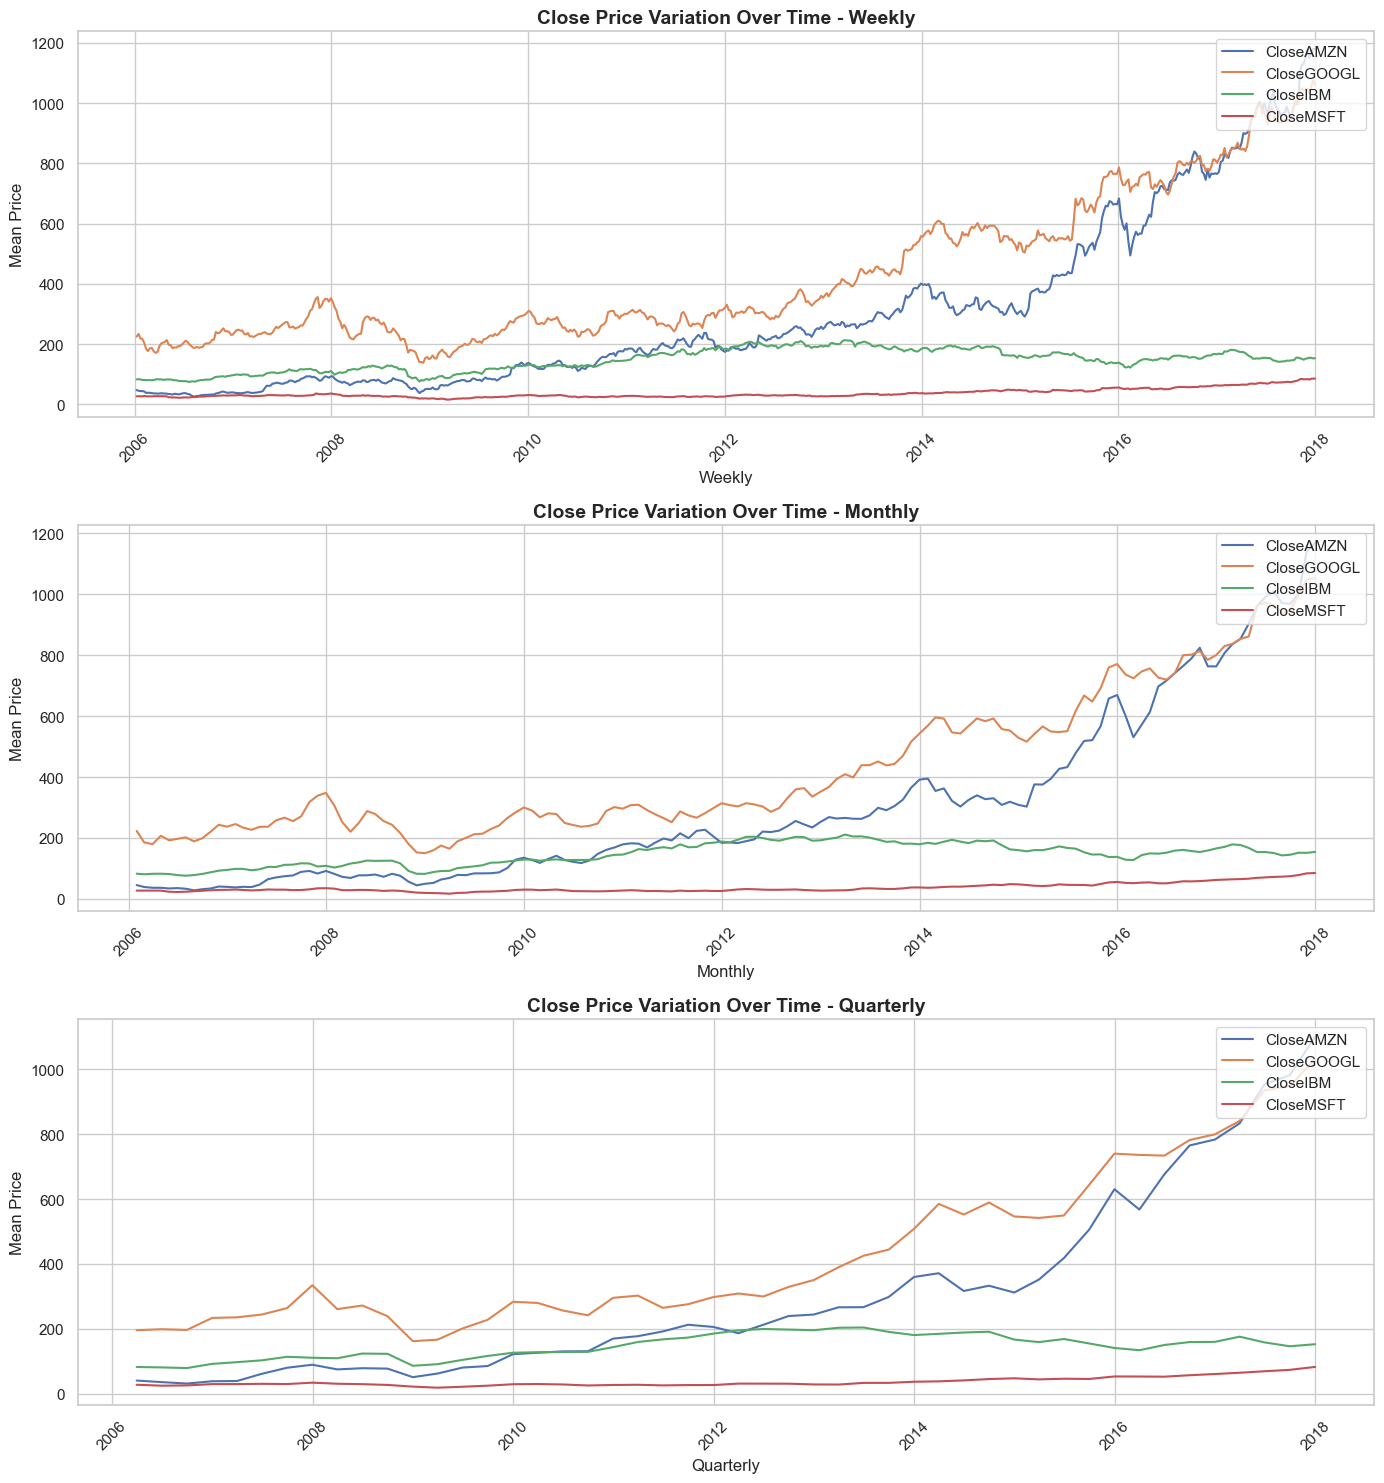

In [20]:
# Diving the Data into Weekly, Monthly, and Quarterly Windows



# Make a deep copy and set 'Date' as index
integrated_df_copy = integrated_df.copy(deep=True)

# Ensure 'Date' column is parsed and set as datetime index
if 'Date' in integrated_df_copy.columns:
    integrated_df_copy['Date'] = pd.to_datetime(integrated_df_copy['Date'], errors='coerce')
    integrated_df_copy.dropna(subset=['Date'], inplace=True)
    integrated_df_copy.set_index('Date', inplace=True)

# Extract close columns
close_columns = [col for col in integrated_df_copy.columns if 'Close' in col]
close_columns = [col for col in close_columns if not integrated_df_copy[col].isna().all()]

# Safety check
if not close_columns:
    raise ValueError("No valid 'Close' columns with data found in the DataFrame.")

# Create subplots for Weekly, Monthly, and Quarterly plots
fig, axs = plt.subplots(3, 1, figsize=(14, 15))
timeframes = {'Weekly': 'W', 'Monthly': 'M', 'Quarterly': 'Q'}

for ax, (title, freq) in zip(axs, timeframes.items()):
    for col in close_columns:
        resampled = integrated_df_copy[col].resample(freq).mean()
        if not resampled.isna().all():
            ax.plot(resampled.index, resampled.values, label=col)
    ax.set_title(f'Close Price Variation Over Time - {title}', fontsize=14, fontweight='bold')
    ax.set_xlabel(title)
    ax.set_ylabel('Mean Price')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [21]:
# Create data instances from the master data frame using decided window size and window stride



In [22]:
# Check the number of data points generated


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [23]:
# Check if the datasets are compatible inputs to neural networks



## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [24]:
# Create a function that creates a simple RNN model according to the model configuration arguments



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [25]:
# Find an optimal configuration of simple RNN



In [26]:
# Find the best configuration based on evaluation metrics



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [27]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model



Plotting the actual vs predicted values

In [28]:
# Predict on the test data and plot



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [29]:
# Compute the performance of the model on the testing data set



### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [30]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [31]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [32]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [33]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [34]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [35]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [36]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [37]:
# Find an optimal configuration of simple RNN



In [38]:
# Find the best configuration



In [39]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [40]:
# Compute the performance of the model on the testing data set



In [41]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [42]:
# Find an optimal configuration of advanced RNN



In [43]:
# Find the best configuration



In [44]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [45]:
# Compute the performance of the model on the testing data set



In [46]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.